In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
from sklearn.metrics import confusion_matrix as conmat, f1_score
from pprint import pprint

In [2]:
if not os.path.isfile('../imgs.npy'):
    imgs, labels = list(), list()

    for i in range(2):
        for j in range(2):
            for k in range(12):
                for l in range(2):
                    S = "{}_{}_{}_{}".format(i,j,k,l)
                    files = glob("../../assignment1/q1/images/{}/*.jpg".format(S))
                    for file in files:
                        imgs.append(cv2.imread(file))
                        labels.append([i,j,k,l])

    imgs = np.array(imgs, dtype=float)/255.0
    labels = np.array(labels, dtype=int)

    np.save("../imgs.npy",imgs)
    np.save("../labels.npy",labels)
else:
    imgs, labels = np.load("../imgs.npy"), np.load("../labels.npy")

In [3]:
def shuffle(a,b):
    indices = np.arange(a.shape[0])
    np.random.shuffle(indices)
    a = a[indices]
    b = b[indices]
    return a,b

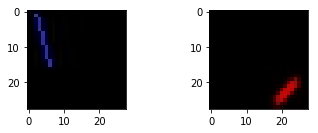

[1 0 7 0] [0 1 3 1]


In [4]:
imgs, labels = shuffle(imgs,labels)
imgstr, labelstr = imgs[:76000], labels[:76000]
imgste, labelste = imgs[76000:], labels[76000:]
plt.subplot(2,2,1)
plt.imshow(imgstr[-1])
plt.subplot(2,2,2)
plt.imshow(imgste[-1])
plt.show()
print(labelstr[-1], labelste[-1])

In [5]:
# one hot encoding
def onehot(classes, tensor):
    N = tensor.shape[0]
    a = np.zeros((N, classes), dtype=int)
    for i,t in enumerate(tensor):
        a[i][t] = 1
    return a

In [6]:
anglestr = onehot(12, labelstr[:,2])
angleste = onehot(12, labelste[:,2])
print (labelstr[-1], anglestr[-1])
print (labelste[-1], angleste[-1])
print(imgstr.shape, anglestr.shape)

[1 0 7 0] [0 0 0 0 0 0 0 1 0 0 0 0]
[0 1 3 1] [0 0 0 1 0 0 0 0 0 0 0 0]
(76000, 28, 28, 3) (76000, 12)


In [7]:
# defining the input and output placeholders
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 3], name="X")
y0 = tf.placeholder(tf.float32, shape=[None], name="y0")
y1 = tf.placeholder(tf.float32, shape=[None], name="y1")
y2 = tf.placeholder(tf.float32, shape=[None], name="y2")
y3 = tf.placeholder(tf.float32, shape=[None, 12], name="y3")
    
conv1_filters=6
conv2_filters=8

# the convolution filters
conv1 = tf.layers.conv2d(X, filters=conv1_filters, kernel_size=5, padding='SAME', activation=None, name='conv1')
conv1_relu = tf.nn.relu(conv1, name='conv1_relu')
pool1 = tf.nn.max_pool(conv1_relu, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', name='pool1')
conv2 = tf.layers.conv2d(pool1, filters=conv2_filters, kernel_size=5, padding='SAME', activation=None, name='conv2')
conv2_relu = tf.nn.relu(conv2, name='conv2_relu')
pool2 = tf.nn.max_pool(conv2_relu, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', name='pool2')
flat = tf.reshape(pool2, shape=[-1, np.prod([v.value for v in pool2.shape[1:]])])

# first head for length
fc10 = tf.layers.dense(flat, 32, activation=tf.nn.relu)
fc20 = tf.layers.dense(fc10, 1)
fc20_r = tf.reshape(fc20, shape=[-1])
y0_ = tf.nn.sigmoid(fc20)
xentropy0 = tf.nn.sigmoid_cross_entropy_with_logits(labels=y0, logits=fc20_r)
loss0 = tf.reduce_mean(xentropy0)
correct0 = tf.cast(tf.equal(tf.reshape(tf.round(y0_),shape=[-1]),y0),tf.int32)

# second head for width
fc11 = tf.layers.dense(flat, 32, activation=tf.nn.relu)
fc21 = tf.layers.dense(fc11, 1)
fc21_r = tf.reshape(fc21, shape=[-1])
y1_ = tf.nn.sigmoid(fc21)
xentropy1 = tf.nn.sigmoid_cross_entropy_with_logits(labels=y1, logits=fc21_r)
loss1 = tf.reduce_mean(xentropy1)
correct1 = tf.cast(tf.equal(tf.reshape(tf.round(y1_),shape=[-1]),y1),tf.int32)

# third head for color
fc12 = tf.layers.dense(flat, 32, activation=tf.nn.relu)
fc22 = tf.layers.dense(fc12, 1)
fc22_r = tf.reshape(fc22, shape=[-1])
y2_ = tf.nn.sigmoid(fc22)
xentropy2 = tf.nn.sigmoid_cross_entropy_with_logits(labels=y2, logits=fc22_r)
loss2 = tf.reduce_mean(xentropy2)
correct2 = tf.cast(tf.equal(tf.reshape(tf.round(y2_),shape=[-1]),y2),tf.int32)

# fourth head for angle
fc13 = tf.layers.dense(flat, 128, activation=tf.nn.relu)
fc23 = tf.layers.dense(fc13, 12)
y3_ = tf.nn.softmax(fc23)
xentropy3 = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=fc23, labels=tf.argmax(y3,1))
loss3 = tf.reduce_mean(xentropy3)
correct3 = tf.cast(tf.nn.in_top_k(y3_,tf.argmax(y3,1),1), tf.int32)

# overall loss is sum of all losses
loss = loss0+loss1+loss2+2*loss3

# backpropagate on loss
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

# a prediction is correct only if all heads predict correct labels
correct = tf.cast((correct0+correct1+correct2+correct3)/4, tf.int32)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

initer = tf.global_variables_initializer()
saver = tf.train.Saver()


In [8]:
epochs = 16
batch_size = 1000

In [9]:
accur_list = np.zeros((epochs,), dtype=float)
loss_list = np.zeros((epochs,), dtype=float)

sess = tf.Session()

with sess.as_default():
    initer.run()
    for epoch in range(epochs):
        imgstr, labelstr = shuffle(imgstr,labelstr)
        anglestr = onehot(12, labelstr[:,2])
        for i in range(int(76000/batch_size)):
            X_batch = imgstr[i*batch_size:(i+1)*batch_size]
            y0_batch = labelstr[:,0][i*batch_size:(i+1)*batch_size]
            y1_batch = labelstr[:,1][i*batch_size:(i+1)*batch_size]
            y2_batch = labelstr[:,3][i*batch_size:(i+1)*batch_size]
            y3_batch = anglestr[i*batch_size:(i+1)*batch_size]
            tmp,_ = sess.run((loss,training_op), feed_dict = {X:X_batch, y3:y3_batch, y0:y0_batch, y1:y1_batch, y2:y2_batch})
            loss_list[epoch] += tmp
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y3:y3_batch, y0:y0_batch, y1:y1_batch, y2:y2_batch})
        acc_test = accuracy.eval(feed_dict={X:imgste, y3:angleste, y0:labelste[:,0], y1:labelste[:,1], y2:labelste[:,3]})
        accur_list[epoch] = acc_test
        print("Epoch:",epoch+1, "Loss:", loss_list[epoch], "Train accuracy:", acc_train, "test accuracy:", acc_test)
    out0, out1, out2, out3 = sess.run((y0_,y1_,y2_,y3_), feed_dict={X:imgste, y3:angleste, y0:labelste[:,0], y1:labelste[:,1], y2:labelste[:,3]})

Epoch: 1 Loss: 408.1022334098816 Train accuracy: 0.376 test accuracy: 0.358
Epoch: 2 Loss: 153.59004414081573 Train accuracy: 0.775 test accuracy: 0.7729
Epoch: 3 Loss: 77.97648710012436 Train accuracy: 0.878 test accuracy: 0.8701
Epoch: 4 Loss: 51.200943291187286 Train accuracy: 0.93 test accuracy: 0.91745
Epoch: 5 Loss: 37.517192631959915 Train accuracy: 0.944 test accuracy: 0.9451
Epoch: 6 Loss: 31.934804618358612 Train accuracy: 0.97 test accuracy: 0.96205
Epoch: 7 Loss: 23.338326692581177 Train accuracy: 0.98 test accuracy: 0.97385
Epoch: 8 Loss: 19.12477070093155 Train accuracy: 0.986 test accuracy: 0.979
Epoch: 9 Loss: 15.660615399479866 Train accuracy: 0.995 test accuracy: 0.9843
Epoch: 10 Loss: 13.338870525360107 Train accuracy: 0.994 test accuracy: 0.9877
Epoch: 11 Loss: 11.112141996622086 Train accuracy: 0.999 test accuracy: 0.989
Epoch: 12 Loss: 9.339504405856133 Train accuracy: 0.994 test accuracy: 0.99275
Epoch: 13 Loss: 8.401570983231068 Train accuracy: 0.994 test accura

In [10]:
gr = tf.get_default_graph()
conv1_wts = gr.get_tensor_by_name('conv1/kernel:0').eval(session=sess)
conv2_wts = gr.get_tensor_by_name('conv2/kernel:0').eval(session=sess)

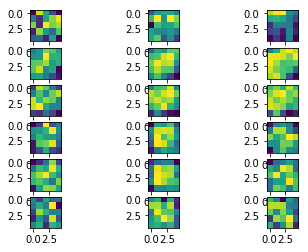

In [11]:
# 6 filters of conv layer 1
for i in range(3):
    for j in range(conv1_filters):
        plt.subplot(conv1_filters, 3, j*3+i+1)
        plt.imshow(conv1_wts[:,:,i,j])
plt.show()

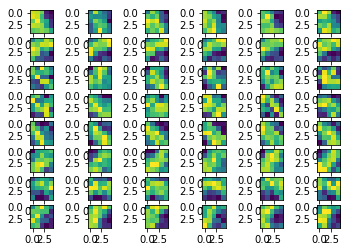

In [12]:
# 8 filters of conv layer 2
for i in range(6):
    for j in range(conv2_filters):
        plt.subplot(conv2_filters, 6, j*6+i+1)
        plt.imshow(conv2_wts[:,:,i,j])
plt.show()

In [13]:
cv1_relu, cv2_relu = sess.run((conv1_relu, conv2_relu), feed_dict={X:imgste[:6], y3:angleste[:6], y0:labelste[:6,0], y1:labelste[:6,1], y2:labelste[:6,3]})

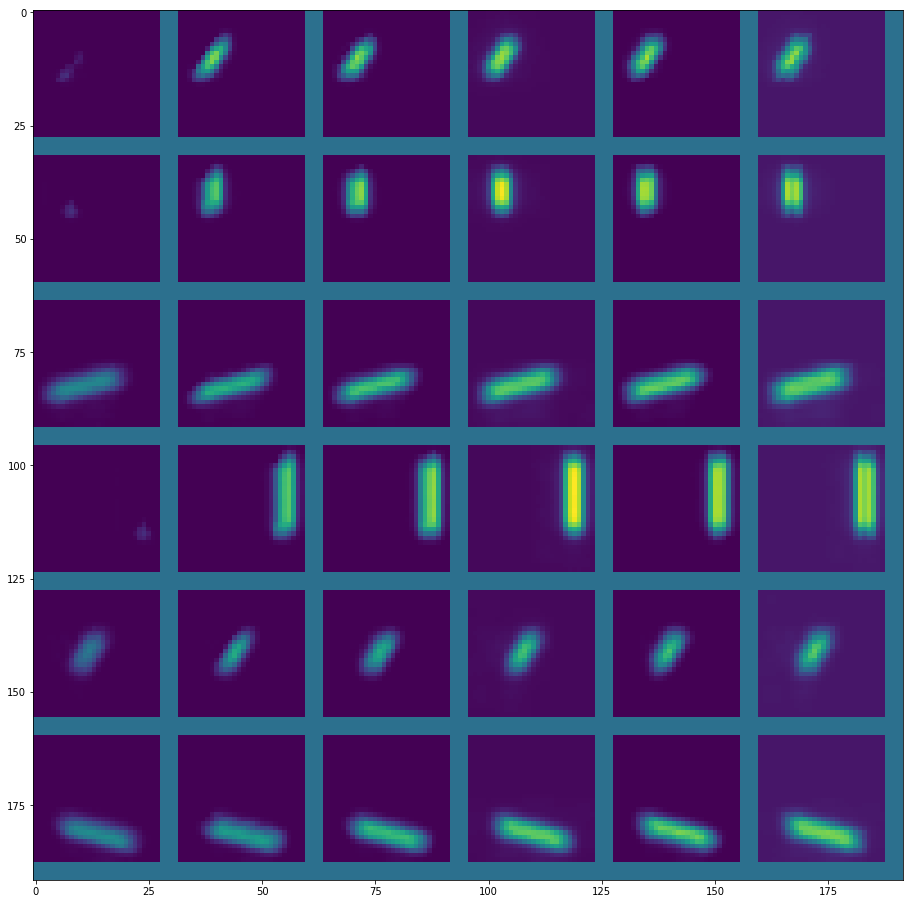

In [14]:
# 6 output each for 6 images for conv1
cv1_display_output = np.ones((cv1_relu.shape[0]*(cv1_relu.shape[1]+4),(cv1_relu.shape[2]+4)*cv1_relu.shape[3]), dtype=float)
for i in range(cv1_relu.shape[0]):
    for j in range(cv1_relu.shape[3]):
        tmp1 = i*(cv1_relu.shape[1]+4)
        tmp2 = (cv1_relu.shape[2]+4)*j
        cv1_display_output[tmp1:tmp1+cv1_relu.shape[1], tmp2:tmp2+cv1_relu.shape[2]] = cv1_relu[i,:,:,j]
plt.figure(figsize=(16,16))
plt.imshow(cv1_display_output)
plt.show()

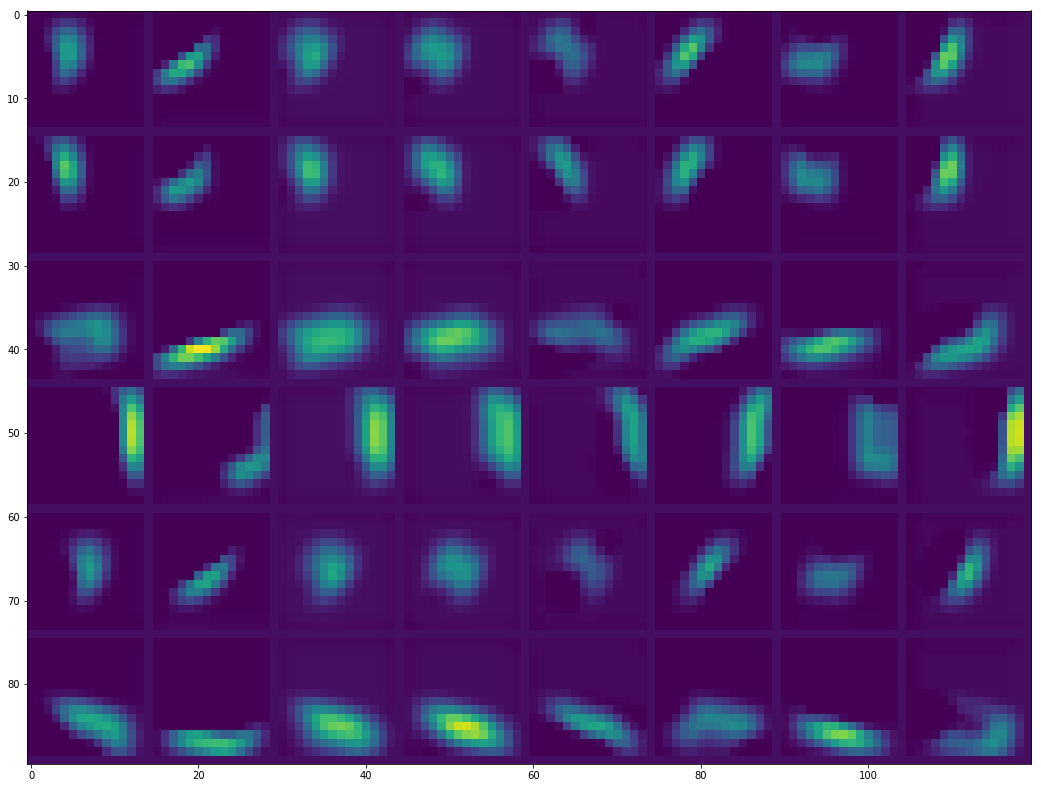

In [15]:
# 8 output each for 6 images for conv2
cv2_display_output = np.ones((cv2_relu.shape[0]*(cv2_relu.shape[1]+1),(cv2_relu.shape[2]+1)*cv2_relu.shape[3]), dtype=float)
for i in range(cv2_relu.shape[0]):
    for j in range(cv2_relu.shape[3]):
        tmp1 = i*(cv2_relu.shape[1]+1)
        tmp2 = (cv2_relu.shape[2]+1)*j
        cv2_display_output[tmp1:tmp1+cv2_relu.shape[1], tmp2:tmp2+cv2_relu.shape[2]] = cv2_relu[i,:,:,j]
plt.figure(figsize=(18,15))
plt.imshow(cv2_display_output)
plt.show()

In [16]:
sess.close()